In [1]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import pandas as pd
import os
import time
from datetime import timedelta

In [2]:
SATELLITE_DATA_PATH = '/storage/data/eumetsat/native/reprojected2/'
PV_DATA_FILENAME = '~/data/pvoutput.org/UK_PV_timeseries_batch.nc'
PV_METADATA_FILENAME = '~/data/pvoutput.org/UK_PV_metadata.csv'

DST_CRS = {
    'ellps': 'WGS84',
    'proj': 'tmerc',  # Transverse Mercator
    'units': 'm'  # meters
}

# Geospatial boundary in Transverse Mercator (meters)
SOUTH = 5513500
NORTH = 6613500
WEST =  -889500
EAST =   410500

## Load and convert PV metadata

In [3]:
pv_metadata = pd.read_csv(PV_METADATA_FILENAME, index_col='system_id')
pv_metadata.dropna(subset=['longitude', 'latitude'], how='any', inplace=True)

In [4]:
# Convert lat lons to Transverse Mercator
pv_metadata['x'], pv_metadata['y'] = rasteriowarp.transform(
    src_crs={'init': 'EPSG:4326'},
    dst_crs=DST_CRS,
    xs=pv_metadata['longitude'].values,
    ys=pv_metadata['latitude'].values)

# Filter 3 PV systems which apparently aren't in the UK!
pv_metadata = pv_metadata[
    (pv_metadata.x >= WEST) &
    (pv_metadata.x <= EAST) &
    (pv_metadata.y <= NORTH) &
    (pv_metadata.y >= SOUTH)]

len(pv_metadata)

2548

## Load and normalise PV power data

In [5]:
%%time
pv_power = xr.load_dataset(PV_DATA_FILENAME)

CPU times: user 13.7 s, sys: 1.95 s, total: 15.6 s
Wall time: 15.6 s


In [6]:
pv_power_selected = pv_power.loc[dict(datetime=slice('2019-01-01', '2019-07-01'))]

In [7]:
pv_power_df = pv_power_selected.to_dataframe().dropna(axis='columns', how='all')
pv_power_df = pv_power_df.clip(lower=0, upper=5E7)
pv_power_df.columns = [np.int64(col) for col in pv_power_df.columns]
pv_power_df = pv_power_df.tz_localize('Europe/London').tz_convert('UTC')

In [8]:
del pv_power
del pv_power_selected

In [9]:
# A bit of hand-crafted cleaning
pv_power_df[30248][:'2019-01-03'] = np.NaN

In [10]:
# Scale to the range [0, 1]
pv_power_df -= pv_power_df.min()
pv_power_df /= pv_power_df.max()

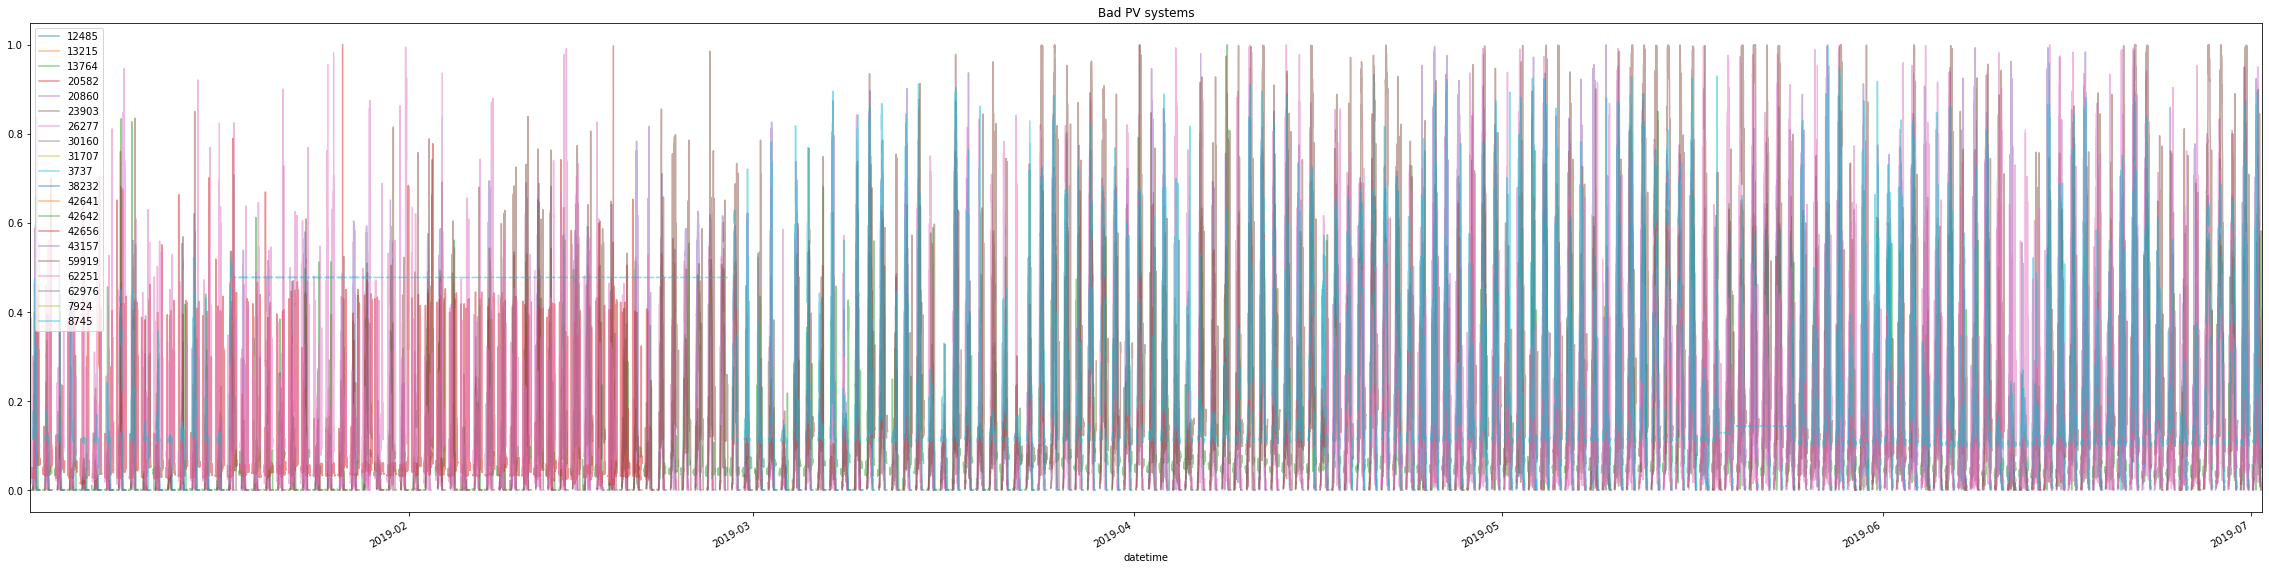

In [11]:
# Drop systems which are producing over night
NIGHT_YIELD_THRESHOLD = 0.4
night_hours = list(range(21, 24)) + list(range(0, 4))
bad_systems = np.where(
    (pv_power_df[pv_power_df.index.hour.isin(night_hours)] > NIGHT_YIELD_THRESHOLD).sum()
)[0]
bad_systems = pv_power_df.columns[bad_systems]
ax = pv_power_df[bad_systems].plot(figsize=(40, 10), alpha=0.5)
ax.set_title('Bad PV systems');

In [12]:
pv_power_df.drop(bad_systems, axis='columns', inplace=True)

In [13]:
%%time
# Interpolate
pv_power_df = pv_power_df.interpolate(limit=3)

CPU times: user 8.38 s, sys: 109 ms, total: 8.49 s
Wall time: 8.5 s


In [14]:
len(pv_power_df.columns)

864

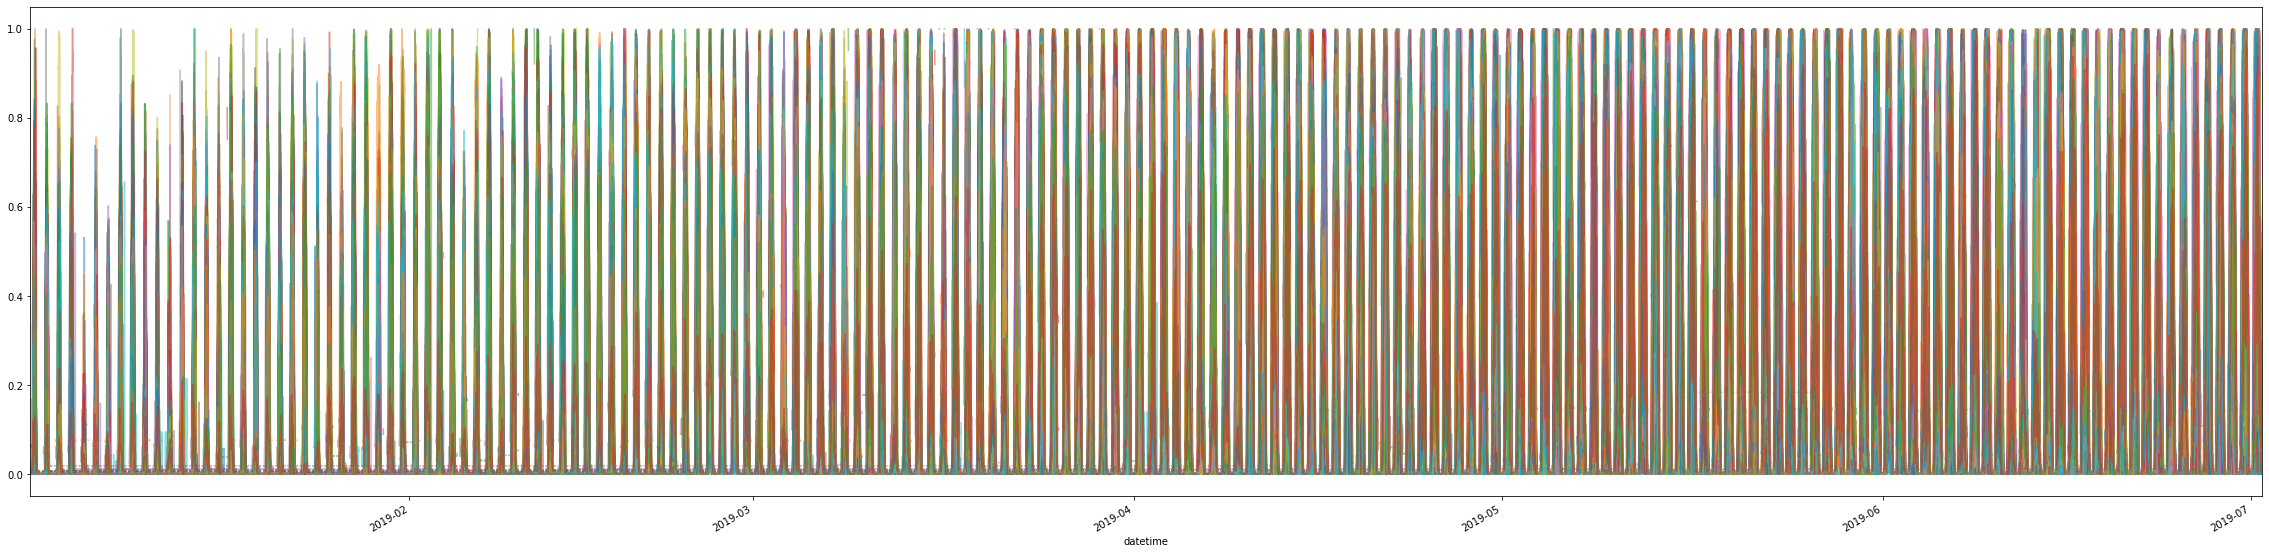

In [15]:
pv_power_df.plot(figsize=(40, 10), alpha=0.5, legend=False);

In [16]:
# Sort the metadata in the same order as the PV power data
pv_metadata = pv_metadata.reindex(pv_power_df.columns, axis='index')

## Load satellite data

In [17]:
from glob import glob
from torch.utils.data import Dataset

In [18]:
class SatelliteLoader(Dataset):
    def __init__(self, file_pattern):
        self._load_sat_index(file_pattern)
        self._data_array_cache = None
        self._last_filename_requested = None
        
    def __getitem__(self, dt):
        sat_filename = self.index[dt]
        if self._data_array_cache is None or sat_filename != self._last_filename_requested:
            self._data_array_cache = xr.open_dataarray(sat_filename)
            self._last_filename_requested = sat_filename
        return self._data_array_cache.sel(time=dt)
        
    def __len__(self):
        return len(self.index)
        
    def _load_sat_index(self, file_pattern):
        sat_filenames = glob(file_pattern)
        sat_filenames.sort()
        
        n_filenames = len(sat_filenames)
        sat_index = []
        for i_filename, sat_filename in enumerate(sat_filenames):
            if i_filename % 10 == 0:
                print('\r {:5d} of {:5d}'.format(i_filename, n_filenames), end='', flush=True)
            data_array = xr.open_dataarray(sat_filename, drop_variables=['x', 'y'])
            sat_index.extend([(sat_filename, t) for t in data_array.time.values])

        sat_index = pd.DataFrame(sat_index, columns=['filename', 'datetime']).set_index('datetime').squeeze()
        self.index = sat_index.tz_localize('UTC')

In [19]:
%%time
sat_loader = SatelliteLoader(os.path.join(SATELLITE_DATA_PATH, '2019*.nc'))
print()

  3240 of  3246
CPU times: user 15.5 s, sys: 734 ms, total: 16.2 s
Wall time: 36.9 s


In [20]:
def get_rectangle_of_satellite_data_lazy(time, centre_x, centre_y, width=128000, height=128000):
    half_width = width / 2
    half_height = height / 2
    
    north = centre_y + half_height
    south = centre_y - half_height
    east = centre_x + half_width
    west = centre_x - half_width
    
    data_array = sat_loader[time]
    data = data_array.loc[dict(
        x=slice(west, east), 
        y=slice(north, south))]
    
    MEAN = 20.444992
    STD = 8.766013
    data = data - MEAN
    data = data / STD 
    
    return data

In [21]:
# Test get rectangle
dt = pd.Timestamp('2019-02-20 10:15')
pv_system_id = pv_metadata.index[0]
x, y = pv_metadata.loc[pv_system_id][['x', 'y']]

In [22]:
%%time
sat_data = get_rectangle_of_satellite_data_lazy(time=dt, centre_x=x, centre_y=y, width=512000, height=512000)

CPU times: user 15.1 ms, sys: 154 µs, total: 15.3 ms
Wall time: 41.7 ms


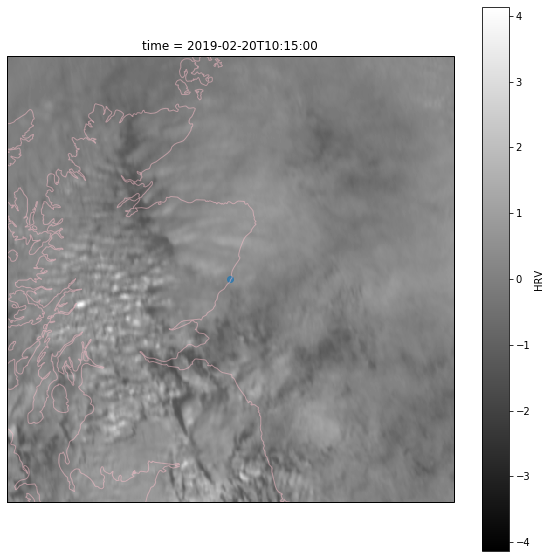

In [23]:
fig = plt.figure(figsize=(10, 10))
crs = ccrs.TransverseMercator()
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', alpha=0.5, color='pink')

img = sat_data.plot.imshow(ax=ax, cmap='gray', origin='upper', add_colorbar=True)
path_collection = ax.scatter(x=x, y=y, alpha=0.7)

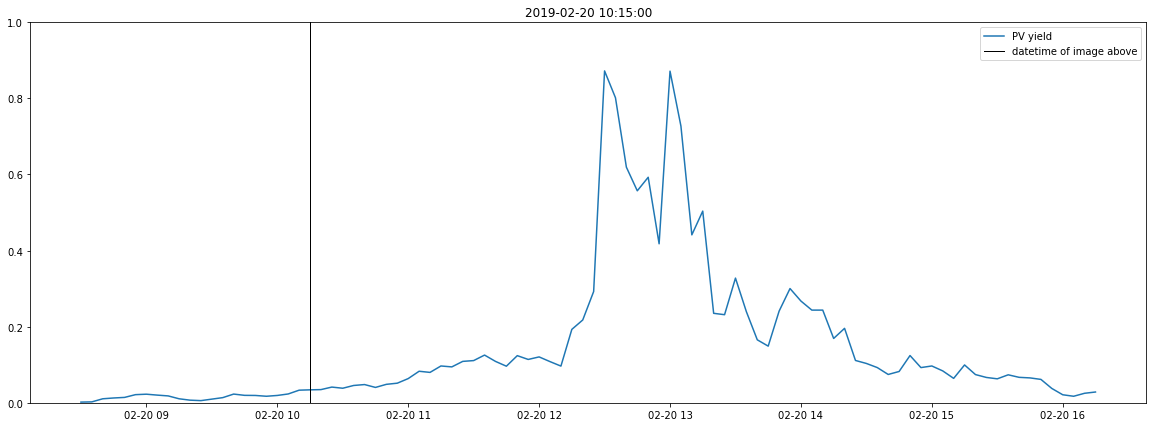

In [24]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(
    pv_power_df[pv_system_id][dt - timedelta(hours=6):dt + timedelta(hours=6)], 
    label='PV yield')
ax.plot((dt, dt), (0, 1), linewidth=1, color='black', label='datetime of image above')
ax.legend()
ax.set_title(dt)
ax.set_ylim((0, 1));

In [25]:
del sat_data

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [27]:
torch.cuda.get_device_name(0)

'GeForce RTX 2080 Ti'

In [28]:
class PVDataset(Dataset):
    def __init__(self, train=False):
        self.pv_data = pv_power_df[pv_system_id].dropna()
        self.x, self.y = pv_metadata.loc[pv_system_id][['x', 'y']]
        self.sat_loader = sat_loader
        self.datetime_index = self.pv_data.index.intersection(self.sat_loader.index.index)
        
        train_test_split = int(len(self.datetime_index) / 5)
        if train:
            self.datetime_index = self.datetime_index[train_test_split:]
        else:
            self.datetime_index = self.datetime_index[:train_test_split]

    def __len__(self):
        return len(self.datetime_index)
    
    def __getitem__(self, idx):
        dt = self.datetime_index[idx]
        pv_data = self.pv_data.loc[dt]
        sat_data = get_rectangle_of_satellite_data_lazy(time=dt, centre_x=self.x, centre_y=self.y)
        sat_data = sat_data.values
        sat_data = sat_data[np.newaxis]
        pv_data = np.array([pv_data])
        
        if any(np.isnan(pv_data).flatten()) or any(np.isnan(sat_data).flatten()):
            print('NaNs detected!  Trying again!')
            new_idx = np.random.randint(low=0, high=len(self)-1)
            return self[new_idx]
        
        return torch.cuda.FloatTensor(sat_data), torch.cuda.FloatTensor(pv_data)

In [29]:
%%time
pv_dataset_test = PVDataset(train=False)
len(pv_dataset_test)

CPU times: user 3.15 ms, sys: 0 ns, total: 3.15 ms
Wall time: 2.57 ms


5400

In [30]:
%%time
pv_dataset_train = PVDataset(train=True)
len(pv_dataset_train)

CPU times: user 3.4 ms, sys: 0 ns, total: 3.4 ms
Wall time: 2.75 ms


21600

In [31]:
%%time
sat_data, pv_data = pv_dataset_test[150]
print(sat_data.shape)
print(pv_data.shape)

torch.Size([1, 128, 128])
torch.Size([1])
CPU times: user 2.39 s, sys: 140 ms, total: 2.53 s
Wall time: 2.53 s


In [32]:
dataloader = DataLoader(pv_dataset_train, batch_size=16, shuffle=True, drop_last=True)

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # x is now <batch_size>, 6, 62, 62.  
        # 62 is 124 / 2.  124 is the 128-dim input - 4
        x = self.pool(F.relu(self.conv2(x)))
        # x is now <batch_size>, 16, 29, 29
        x = x.view(-1, 16 * 29 * 29)
        # x is now <batch_size>, 16 x 29 x 29
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().cuda()

In [34]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
loss_func = nn.MSELoss()

In [43]:
%%time
STATS_PERIOD = 50

losses = []
n = len(dataloader)
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0

    t0 = time.time()
    for i_batch, (inputs, target) in enumerate(dataloader):
        print('\r Epoch:', epoch, 'Batch:', i_batch, 'of', n, end='', flush=True)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i_batch % STATS_PERIOD == STATS_PERIOD - 1:    # print every 2000 mini-batches
            t1 = time.time()
            mean_loss = running_loss / STATS_PERIOD
            losses.append(mean_loss)
            print('\n[%d, %5d] loss: %.3f; time= %.2f s' %
                  (epoch + 1, i_batch + 1, mean_loss, t1 - t0))
            running_loss = 0.0
            t0 = time.time()

print('Finished Training')

 Epoch: 0 Batch: 49 of 1350
[1,    50] loss: 0.020; time= 81.09 s
 Epoch: 0 Batch: 99 of 1350
[1,   100] loss: 0.023; time= 79.35 s
 Epoch: 0 Batch: 149 of 1350
[1,   150] loss: 0.023; time= 78.86 s
 Epoch: 0 Batch: 199 of 1350
[1,   200] loss: 0.021; time= 77.46 s
 Epoch: 0 Batch: 249 of 1350
[1,   250] loss: 0.022; time= 78.35 s
 Epoch: 0 Batch: 282 of 1350NaNs detected!  Trying again!
 Epoch: 0 Batch: 299 of 1350
[1,   300] loss: 0.020; time= 79.54 s
 Epoch: 0 Batch: 349 of 1350
[1,   350] loss: 0.021; time= 80.32 s
 Epoch: 0 Batch: 399 of 1350
[1,   400] loss: 0.020; time= 79.81 s
 Epoch: 0 Batch: 449 of 1350
[1,   450] loss: 0.019; time= 78.94 s
 Epoch: 0 Batch: 499 of 1350
[1,   500] loss: 0.018; time= 79.75 s
 Epoch: 0 Batch: 549 of 1350
[1,   550] loss: 0.018; time= 79.61 s
 Epoch: 0 Batch: 599 of 1350
[1,   600] loss: 0.017; time= 80.02 s
 Epoch: 0 Batch: 649 of 1350
[1,   650] loss: 0.017; time= 79.86 s
 Epoch: 0 Batch: 699 of 1350
[1,   700] loss: 0.018; time= 79.57 s
 Epoch

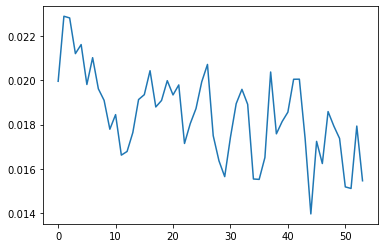

In [44]:
plt.plot(losses);

In [45]:
test_i = 0
for inputs, target in DataLoader(pv_dataset_test, batch_size=64, shuffle=False, drop_last=True):
    test_i += 1
    if test_i == 200:
        break

In [46]:
output = net(inputs)

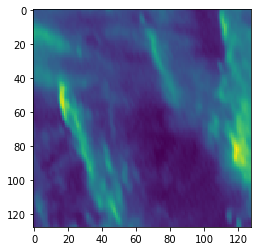

In [47]:
i = 30
plt.imshow(inputs[i, 0].cpu(), origin='upper')

In [48]:
output[i, 0].detach().cpu()

tensor(-0.0028)

In [49]:
target[i, 0].detach().cpu()

tensor(0.0069)

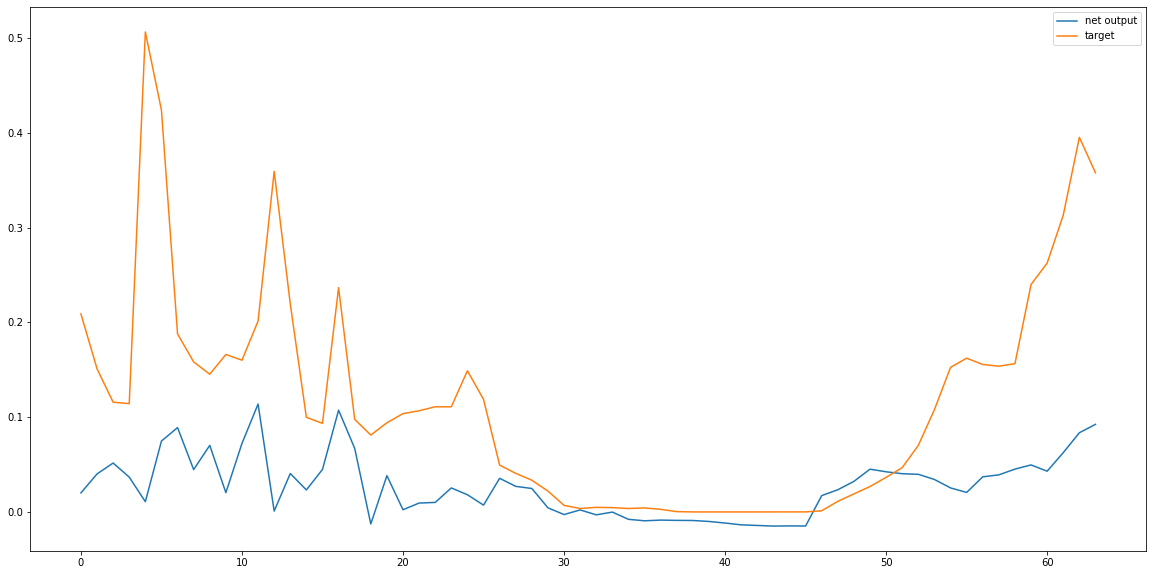

In [50]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(output[:, 0].detach().cpu(), label='net output')
ax.plot(target[:, 0].detach().cpu(), label='target')
ax.legend()